In [4]:
import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf
import PIL

# download corpus

In [5]:
url = 'http://mattmahoney.net/dc/'

def download(filename, expected_bytes):
    if not os.path.exists(filename):
        print('start downloading...')
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?'
        )
    return filename

In [6]:
filename = download('text8.zip', 31344016)

start downloading...
Found and verified text8.zip


In [9]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

In [10]:
vocabulary = read_data(filename)

In [11]:
print('Data size ', len(vocabulary))

Data size  17005207


In [12]:
print(vocabulary[0:100])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


# build dataset

In [13]:
vocabulary_size = 100000

In [17]:
from icecream import ic

In [18]:
def build_dataset(words, n_words):
    ic()
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [19]:
data, count, dictionary, reversed_dictionary = build_dataset(vocabulary, vocabulary_size)

ic| <ipython-input-18-e8b652f45a5d>:2 in build_dataset() at 12:53:34.239


In [20]:
print("Most common words (+UNK)", count[:5])

Most common words (+UNK) [['UNK', 189230], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]


In [22]:
ic(data[:10])

ic| data[:10]: [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [24]:
print([reversed_dictionary[i] for i in data[:10]])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


# generate batch

In [26]:
data_index = 0

In [27]:
def generate_batch(batch_size, cbow_window):
    global data_index
    assert cbow_window % 2 == 1
    span = 2 * cbow_window + 1
    
    batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    buffer = collections.deque(maxlen = span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    for i in range(batch_size):
        target = cbow_window
        target_to_avoid = [cbow_window]
        
        col_idx = 0
        for j in range(span):
            if j == span // 2:
                continue
            batch[i, col_idx] = buffer[j]
            col_idx += 1
        labels[i, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [28]:
num_steps = 230001

In [30]:
batch_size = 128
embedding_size = 128
cbow_window = 1
num_skips = 2
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size // 2))
valid_examples = np.append(valid_examples, random.sample(range(1000, 1000+valid_window), valid_size // 2))
num_sampled = 64

In [31]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2 * cbow_window])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    # embedding, vector for each word in the vocabulary
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                  stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    # this might efficiently find the embeddings for given ids (traind dataset)
    # manually doing this might not be efficient given there are 50000 entries in embeddings
    embeds = None
    for i in range(2 * cbow_window):
        embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:, i])
        print('embedding %d shape: %s' % (i, embedding_i.get_shape().as_list()))
        emb_x, emb_y = embedding_i.get_shape().as_list()
        if embeds is None:
            embeds = tf.reshape(embedding_i, [emb_x, emb_y, 1])
        else:
            embeds = tf.concat([embeds, tf.reshape(embedding_i, [emb_x, emb_y, 1])], 2)

    assert embeds.get_shape().as_list()[2] == 2 * cbow_window
    print("Concat embedding size: %s" % embeds.get_shape().as_list())
    avg_embed = tf.reduce_mean(embeds, 2, keep_dims=False)
    print("Avg embedding size: %s" % avg_embed.get_shape().as_list())

    loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases,
                                         labels=train_labels,
                                         inputs=avg_embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    # Adagrad is required because there are too many things to optimize
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

W0907 21:41:21.231956 4456740288 deprecation.py:323] From //anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


embedding 0 shape: [128, 128]
embedding 1 shape: [128, 128]
Concat embedding size: [128, 128, 2]
Avg embedding size: [128, 128]


W0907 21:41:21.426461 4456740288 deprecation.py:506] From //anaconda3/lib/python3.7/site-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0907 21:41:21.457386 4456740288 deprecation.py:506] From <ipython-input-31-000d8868de04>:53: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


# train

In [34]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, cbow_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 274.472046
Nearest to about: icrm, himmel, geographically, sheik, germantown, livland, cornfield, prosecute,
Nearest to for: eden, oilseed, touchdowns, cht, tarikh, oecd, brainf, broadcast,
Nearest to such: engender, fund, tuyere, temptress, investigations, mismo, monorail, modernism,
Nearest to as: canonical, conceptualized, rebooting, genera, codenamed, seashells, contractive, cimeti,
Nearest to six: scofield, peeresses, zamyatin, theatre, cruder, fireplace, calibrated, cueva,
Nearest to and: peirce, saverio, interpretlanguage, photovoltaic, rolodex, flail, muzorewa, extenuating,
Nearest to he: significations, tapi, apec, cricetus, murmuring, tellers, platt, berliners,
Nearest to often: stipulated, lign, clash, winter, rfd, vertebral, abort, gypsies,
Nearest to know: pleshette, hemorrhagic, preaching, yalu, spiralled, absorbs, daw, solicitor,
Nearest to additional: ellesmere, smallpox, kickboxing, limbourg, soldiery, citizen, experiment, barding,
N

# visualization

In [42]:
def plot_with_labels(low_dim_embs, labels, filename='tsne1.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)


try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib
    matplotlib.use('agg')
    import matplotlib.pyplot as plt
    # 因为我们的embedding的大小为128维，没有办法直接可视化
    # 所以我们用t-SNE方法进行降维
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=8000)
    # 只画出500个词的位置
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reversed_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

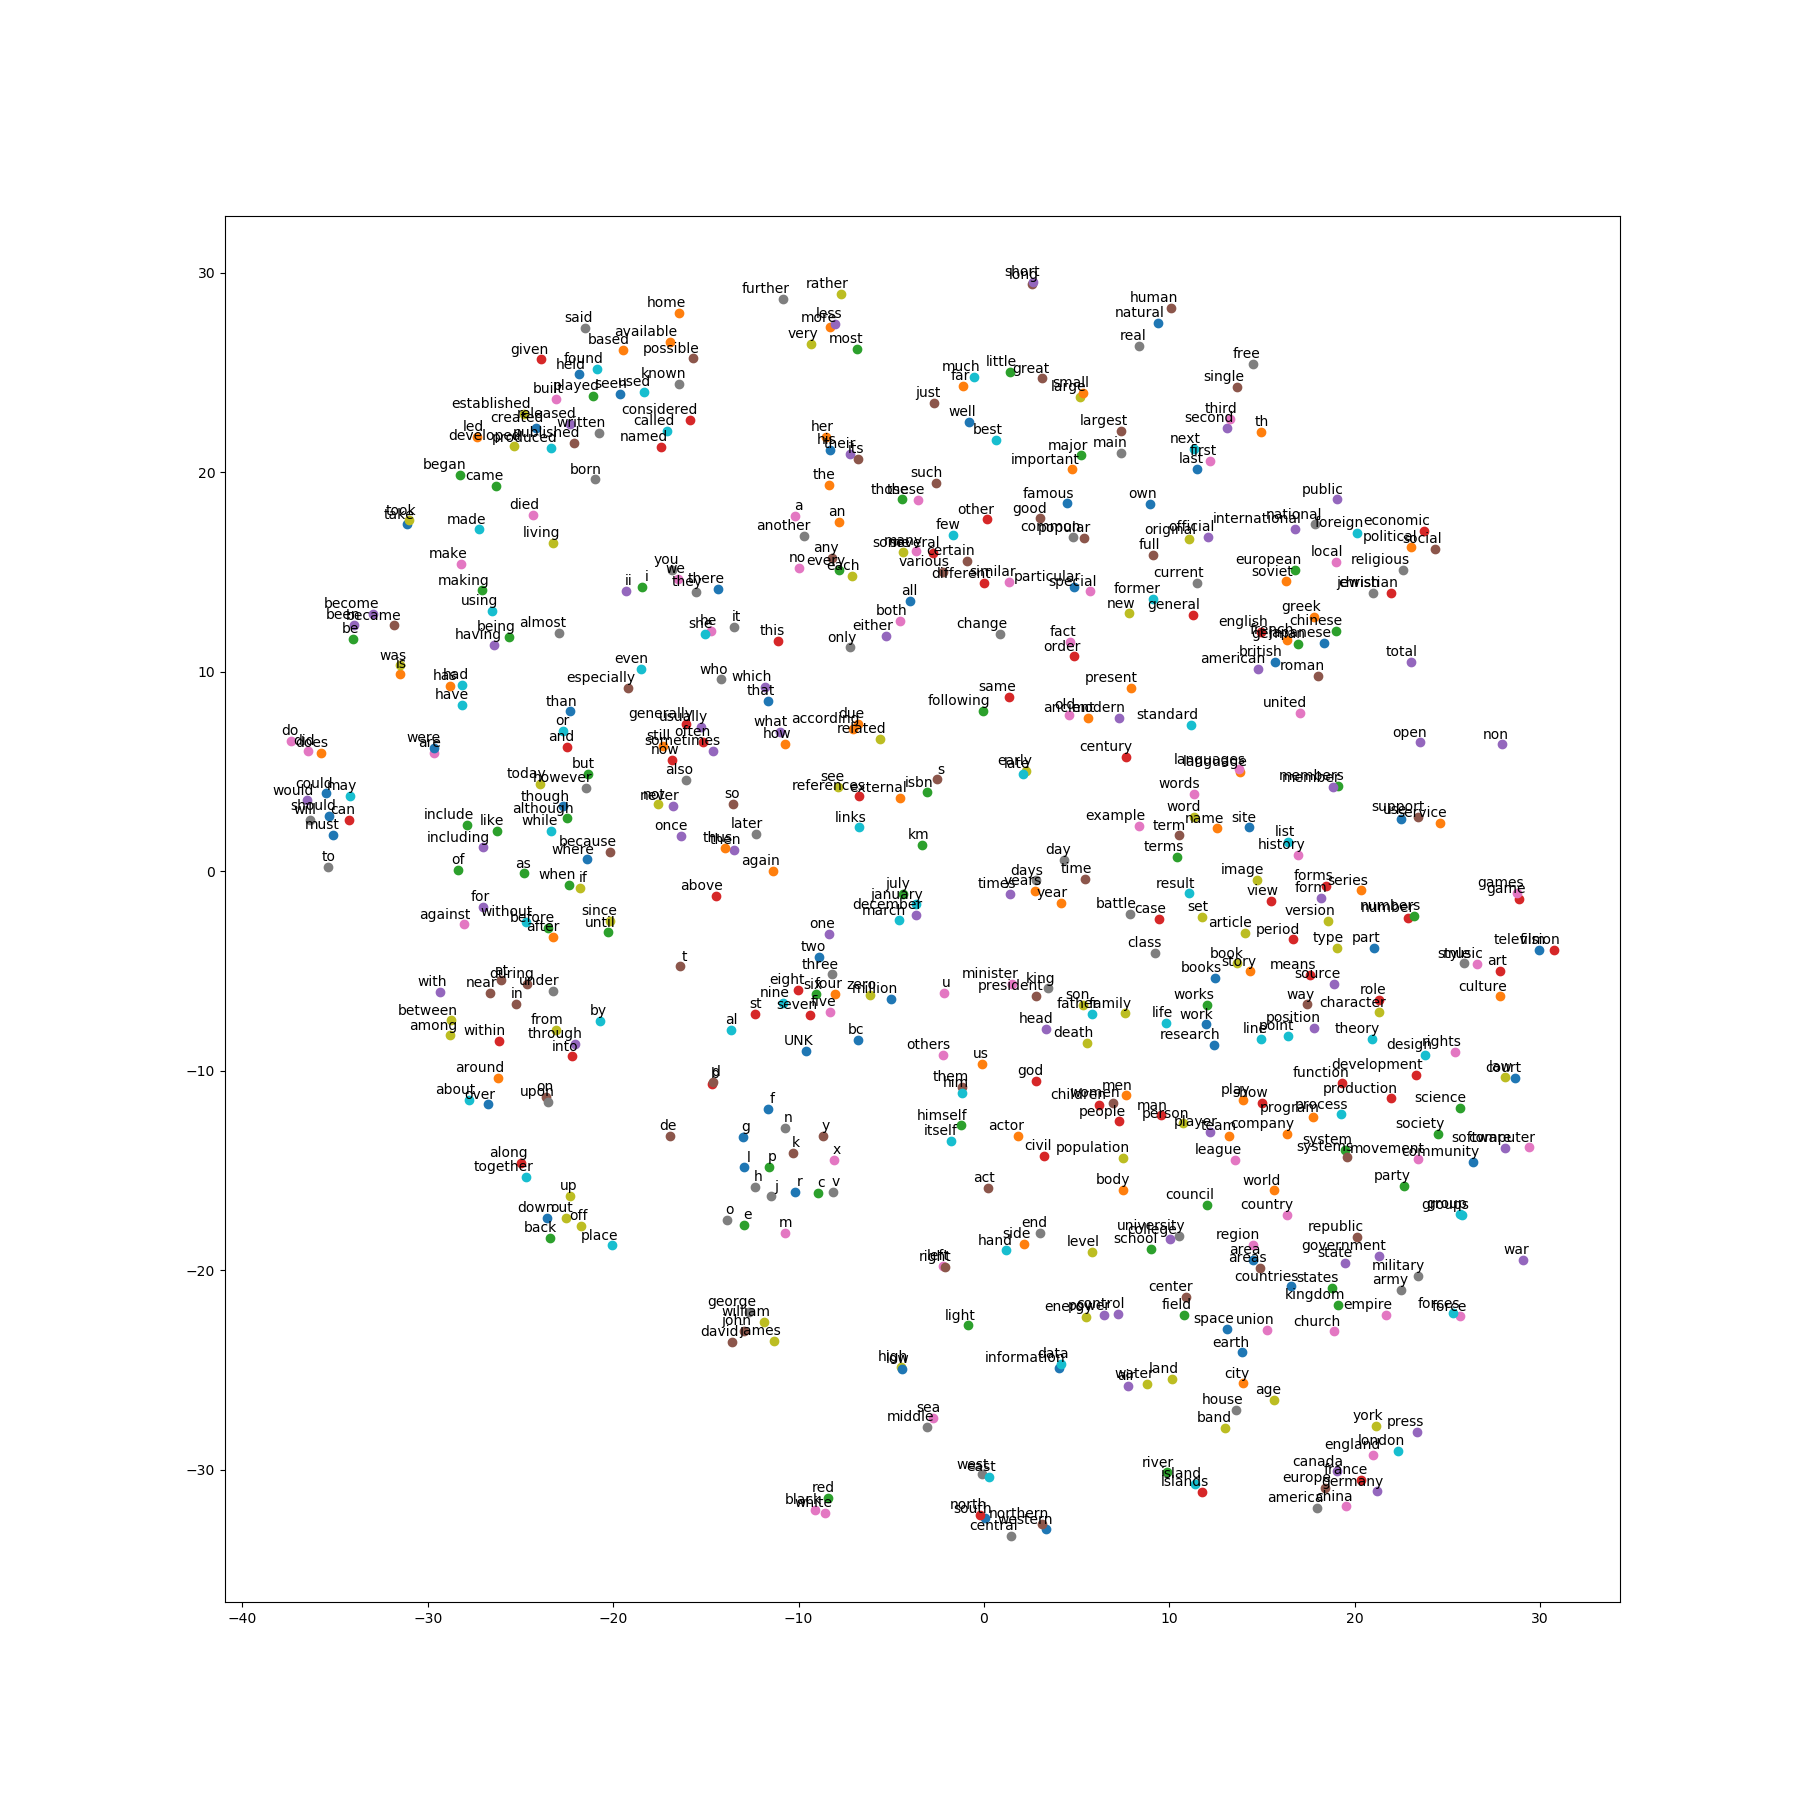

In [43]:
PIL.Image.open('./tsne1.png')